EPITA 2019 MLRF practice_05-01_image_classification v2019-06-03_193129 by Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice 05 part 01: Image classification

## 0. Introduction

We will demonstrate how to build on the BoVW technique you implemented for the last session in order to recognize the category an image belongs to.

It consists in building a simple classifier using the BoVW descriptors which can be computed with the same method as the practice session 4.
However, you way want to seize this opportunity to improve the method you implemented, and maybe use a more powerful feature encoding technique, like the VLAD or even the Fisher Vector…


This session is inspired by this cool 2018 meme about animals which look like food:
![Cranberry muffins and chihuahuas](img/practice_05/meme_full.jpg)


In this session, you will learn how to produce results like the ones displayed below (first rows: chihuahuas, second rows: cranberry muffins, color and title indicates whether the classifier produced the right result).
![Sample output](img/practice_05/results.png)



We will proceed in 9 steps:

1. Load resources
2. Train a BoVW model
3. Split the dataset into training and validation sets
4. Compute the BoVW descriptor for each image
5. Prepare training structures
6. Train a classifier and evaluate its performance
7. Display some results
8. Test on meme images
9. Compute the results on the test set and export them

### 0.1 Resources
The resources for this session are stored on the network.

Here is a description of the files we provide in the student's archive:
- `meme_jpg/`: contains original meme images, for fun;
- `meme_siftgeo/`: contains SIFT descriptors of original meme images, for fun;
- `test_set_sift/`: contains the SIFT descriptors of the 400 test set images;
- `train_val_set_jpg/`: contains 2694 training and validation images for both classes:
   1416 for the "chihuahua" (`chi`) class, and 1278 for the "muffin" (`muf`) class;
- `train_val_set_siftgeo/`: contains the SIFT descriptors of the training and validation images
   for both classes;
- `sample_results.json`: an example of result file (with random results);
- `README.md`: even more details about the dataset.

**IMPORTANT:** the dataset is **IMBALANCED** and you should take this into account before training
any classifier.


### 0.2 Ground truth format
The ground truth is implicit in this session: the files are stored in directories indicating the category they belong to. This is a very common practice among the various public dataset we can find.

### 0.3  Local descriptors
We provide precomputed SIFT descriptors to save you time.
We also provide a commodity function to help you loading them (see below), just like for the previous session.

# 1. Load resources

In [26]:
# deactivate buggy jupyter completion
%config Completer.use_jedi = False

In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from keras.applications import VGG16
from keras.models import Sequential
from keras import models
from keras import layers
from keras import optimizers
import pandas as pd
%matplotlib inline
import os
import sklearn
import json
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(0)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Make sure the resources location below is correct.**
</div>

In [28]:
# setup the resources location
PATH_TO_RESOURCES = "/home/mados/Documents/TABERNACLE/mlrfrendu/r2/"

### Code to read descriptors
We provide you with the `siftgeo_read_desc(path)` which allows to get the array of descriptors stored in a `.siftgeo` file.

#### About the SIFT descriptors used (`.siftgeo` files)
Descriptors are stored in raw together with the region information provided by the software of Krystian Mikolajczyk.
There is no header (use the file length to find the number of descriptors).
A descriptor takes 168 bytes (floats and ints take 4 bytes, and are stored in little endian):
```
field      field type   description
x          float        horizontal position of the interest point
y          float        vertical position of the interest point
scale      float        scale of the interest region
angle      float        angle of the interest region
mi11       float        affine matrix component
mi12       float        affine matrix component
mi21       float        affine matrix component
mi22       float        affine matrix component
cornerness float        saliency of the interest point
desdim     int          dimension of the descriptors
component  byte*desdim  the descriptor vector (dd components)
```

In [29]:
SIFTGEO_DTYPE = np.dtype([
    ("x", "<f4"),
    ("y", "<f4"),
    ("scale", "<f4"),
    ("angle", "<f4"),
    ("mi11", "<f4"),
    ("mi12", "<f4"),
    ("mi21", "<f4"),
    ("mi22", "<f4"),
    ("cornerness", "<f4"),
    ("desdim", "<i4"),
    ("component", "<u1", 128)
])

def siftgeo_read_full(path):
    return np.fromfile(path, dtype=SIFTGEO_DTYPE)

def siftgeo_read_desc(path):
    desc = siftgeo_read_full(path)["component"]
    if desc.size == 0: 
        desc = np.zeros((0, 128), dtype = 'uint8')
    return desc

We prepare some list of files, for convenience.

In [30]:
ALL_IMGS_CHI = !ls $PATH_TO_RESOURCES/train_val_set_jpg/chi/*.jpg | sort
ALL_SIFT_CHI = !ls $PATH_TO_RESOURCES/train_val_set_siftgeo/chi/*.siftgeo | sort
ALL_IMGS_MUF = !ls $PATH_TO_RESOURCES/train_val_set_jpg/muf/*.jpg | sort
ALL_SIFT_MUF = !ls $PATH_TO_RESOURCES/train_val_set_siftgeo/muf/*.siftgeo | sort

In [31]:
ALL_SIFT_CHI[:5]

['/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/chi/0201.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/chi/0202.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/chi/0203.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/chi/0204.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/chi/0205.siftgeo']

In [32]:
ALL_SIFT_MUF[:5]

['/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/muf/0201.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/muf/0202.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/muf/0203.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/muf/0204.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//train_val_set_siftgeo/muf/0205.siftgeo']

## 2. Train a BoVW model
We want to assign a single vector to each image we will encounter.

We first need to build a BoVW model, exactly like during the previous session.

### 2.1 Select training descriptors
We need **some** descriptors from **all** the classes!

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Select and load descriptors for 100 images of each category.**
</div>

In [33]:
sift_chi_path = np.random.choice(ALL_SIFT_CHI, 100)
sample_descr_chi = np.array([siftgeo_read_desc(sift_path) for sift_path in sift_chi_path])
sample_descr_chi[:5].shape

(5,)

In [34]:
sift_muf_path = np.random.choice(ALL_SIFT_MUF, 100)
sample_descr_muf = np.array([siftgeo_read_desc(sift_path) for sift_path in sift_muf_path])
sample_descr_muf[:5].shape

(5,)

We now have a list of arrays of SIFT descriptors: for each image we have an array of shape `(number of descriptors, SIFT descriptor size)`.

We need to stack those descriptors to produce one big training array of shape `(total number of training descriptors, SIFT descriptor size)`.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Stack your descriptors to prepare your training set for the codebook generation.**
</div>

In [35]:
descr_chi_stacked = np.concatenate(sample_descr_chi, axis=0)
descr_muf_stacked = np.concatenate(sample_descr_muf, axis=0)
train_desc = np.concatenate((descr_chi_stacked, descr_muf_stacked))
train_desc.shape, train_desc.dtype

((83403, 128), dtype('uint8'))

Finally, we convert this array to float32 elements to avoid normalization issues.

In [36]:
train_desc = train_desc.astype(np.float32)

### 2.2 Learn normalization parameters and train a k-Means
We now need to perform some preprocessing on our data: centering and dimension reduction, before training our k-Means.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the mean of your sample and center your data.**
</div>

In [37]:
# TODO
train_mean = np.mean(train_desc, axis=1)
train_desc = train_desc - train_mean[:, np.newaxis]

((128, 64), dtype('float32'))

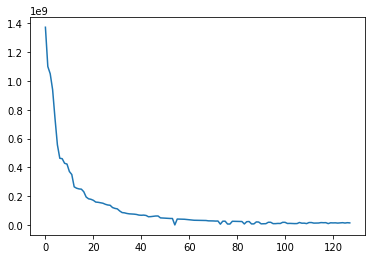

In [38]:
# compute PCA matrix and keep only 64 dimensions
train_cov = np.dot(train_desc.T, train_desc)
eigvals, eigvecs = np.linalg.eig(train_cov)
perm = eigvals.argsort()                   # sort by increasing eigenvalue
plt.plot(eigvals)
pca_transform = eigvecs[:, perm[64:128]]   # eigenvectors for the 64 last eigenvalues
pca_transform.shape, pca_transform.dtype

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Apply the PCA transform to your data.**
</div>

In [39]:
train_desc = np.dot(train_desc, pca_transform)

In [40]:
# Check the shape of your new descriptors: we expect a shape like (BIGNUMBER, 64)
train_desc.shape

(83403, 64)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Train a k-Means with 512 dimensions to compute our codebook.**
</div>

In [41]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [42]:
# fit k-means
kmeans =  MiniBatchKMeans(n_clusters=512, random_state=0).fit(train_desc)

/home/mados/.local/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1558: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)
/home/mados/.local/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1558: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)
/home/mados/.local/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1558: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)


In [43]:
# let's check the shape of the cluster's centers
kmeans.cluster_centers_.shape

(512, 64)

We know have a codebook, and some learned parameters for preprocessing our data.

## 3. Split the dataset into training and validation sets
Before encoding our features, to avoid computing large arrays and splitting them afterhand (hence consuming much memory because of Python computation model), we will first separate the list of files into appropriate sublists for training and validating our model.

**But even before** we need to make sure our dataset is balanced!

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Transform the lists of files we previously defined to make sure our dataset is balanced.**
</div>

*Tip:* Here are the lists we previously defined:
- `ALL_IMGS_CHI`
- `ALL_SIFT_CHI`
- `ALL_IMGS_MUF`
- `ALL_SIFT_MUF`


In [44]:
len(ALL_IMGS_CHI), len(ALL_IMGS_MUF)

(1416, 1278)

In [45]:
minf = min(len(ALL_IMGS_CHI), len(ALL_IMGS_MUF))
# transform the lists
ALL_IMGS_CHI = ALL_IMGS_CHI[:minf]
ALL_SIFT_CHI = ALL_SIFT_CHI[:minf]
ALL_IMGS_MUF = ALL_IMGS_MUF[:minf]
ALL_SIFT_MUF = ALL_SIFT_MUF[:minf]

In [46]:
len(ALL_IMGS_CHI), len(ALL_IMGS_MUF)

(1278, 1278)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using Scikit learn function `sklearn.model_selection.train_test_split(...)`, separate the list of files we previously computed into two subsets each: a training set and a validation set.**
</div>

*Tip:* Here are the lists we previously defined:
- `ALL_IMGS_CHI`
- `ALL_SIFT_CHI`
- `ALL_IMGS_MUF`
- `ALL_SIFT_MUF`

We also want to split the list of images because it will be useful for visualizing the results.

You also may want to **specify the random state** to be able to reproduce your results.

In [47]:
#train / validation split
(train_imgs_chi, val_imgs_chi,
 train_sift_chi, val_sift_chi,
 train_imgs_muf, val_imgs_muf,
 train_sift_muf, val_sift_muf) = sklearn.model_selection.train_test_split(ALL_IMGS_CHI, ALL_SIFT_CHI,
                                                                          ALL_IMGS_MUF, ALL_SIFT_MUF, shuffle=True)
#print(train_sift_chi)
#val_sift_chi

In [48]:
len(train_sift_chi), len(val_sift_chi), len(train_sift_muf), len(val_sift_muf)

(958, 320, 958, 320)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**According to you, why do we call our sets "training" and "validation", and not "training" and "testing"?**
</div>

Un jeu de donné de validation sert à faire de l'hyperparamétrage d'un model dans un environnement non biaisé.

## 4. Compute the BoVW descriptor for each image
We can now encode the local SIFT descriptors of each image using the elements we learned.

Like in the previous session, we will compte a single descriptor of dimension `512` (or something else if you changed the size of the coodebook).

We will however add a couple of improvements over the version used during the last session: 
1. we will project our descriptor to another embedding space using the square root, to simulate an Hellinger kernel;
2. we will perform a L2 normalization of the final descriptor to facilitate linear classification.

We first import an appropriate normalized for L2, to avoid little programming errors.

In [49]:
l2_normalizer = sklearn.preprocessing.Normalizer(norm='l2', copy=True)
l1_normalizer = sklearn.preprocessing.Normalizer(norm='l1', copy=True)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the function below which takes a list of `.siftgeo` files, a training mean, a PCA transform, and a k-Means object and compute the arrays of BoVW descriptors, one for each `.siftgeo` file.**
</div>

In [50]:
def compute_descriptors(siftgeo_filelist, train_mean, pca_transform, kmeans):
    image_descriptors = np.zeros((len(siftgeo_filelist), kmeans.n_clusters), dtype=np.float32)
    
    for ii, descrfile in enumerate(siftgeo_filelist):
        shortname = descrfile.split('/')[-2:]
        print("Indexing %s" % (shortname,))
        # read the descriptors
        desc = siftgeo_read_desc(descrfile)
        if desc.shape[0] == 0:
            # let the descriptor be 0 for all values
            # note that this is bad and the element should be dropped from the index
            print("WARNING: zero descriptor for %s" % (shortname,))
            continue
        
        # center
        desc = desc - np.mean(desc)
        # pca
        desc_in_newbase = desc@pca_transform

        # get cluster ids
        clabels = kmeans.predict(desc_in_newbase)
        #print(centers)

        # compute histogram
        descr_hist, _ = np.histogram(clabels, bins=np.arange(kmeans.n_clusters+1))
        descr_hist = descr_hist.reshape(1,-1)
        # l1 norm
        #desc_hist = l1_normalizer.transform(descr_hist)
        # take the sqrt (Hellinger kernel)
        descr_hist = descr_hist**.05
        # l2 norm
        descr_hist = l2_normalizer.transform(descr_hist)
        descr_hist = descr_hist.flatten()
        # update the index
        image_descriptors[ii] = descr_hist 
    print("Indexing complete.")
    return image_descriptors

**We can now computes the descriptors for each subset.**

Let us just run the previously-defined function in batch.

In [51]:
x_train_chi, x_val_chi, x_train_muf, x_val_muf = [
    compute_descriptors(filelist, train_mean, pca_transform, kmeans) 
    for filelist in (train_sift_chi, val_sift_chi,
                     train_sift_muf, val_sift_muf)]

Indexing ['chi', '0487.siftgeo']
Indexing ['chi', '1088.siftgeo']
Indexing ['chi', '0944.siftgeo']
Indexing ['chi', '0325.siftgeo']
Indexing ['chi', '0399.siftgeo']
Indexing ['chi', '1030.siftgeo']
Indexing ['chi', '1434.siftgeo']
Indexing ['chi', '0842.siftgeo']
Indexing ['chi', '0996.siftgeo']
Indexing ['chi', '0958.siftgeo']
Indexing ['chi', '1154.siftgeo']
Indexing ['chi', '0646.siftgeo']
Indexing ['chi', '0991.siftgeo']
Indexing ['chi', '1437.siftgeo']
Indexing ['chi', '0690.siftgeo']
Indexing ['chi', '1359.siftgeo']
Indexing ['chi', '0688.siftgeo']
Indexing ['chi', '1446.siftgeo']
Indexing ['chi', '0766.siftgeo']
Indexing ['chi', '0866.siftgeo']
Indexing ['chi', '0680.siftgeo']
Indexing ['chi', '1155.siftgeo']
Indexing ['chi', '0736.siftgeo']
Indexing ['chi', '0262.siftgeo']
Indexing ['chi', '0741.siftgeo']
Indexing ['chi', '0713.siftgeo']
Indexing ['chi', '0293.siftgeo']
Indexing ['chi', '1393.siftgeo']
Indexing ['chi', '0555.siftgeo']
Indexing ['chi', '1000.siftgeo']
Indexing [

Indexing ['chi', '0384.siftgeo']
Indexing ['chi', '0670.siftgeo']
Indexing ['chi', '0445.siftgeo']
Indexing ['chi', '1320.siftgeo']
Indexing ['chi', '0998.siftgeo']
Indexing ['chi', '0734.siftgeo']
Indexing ['chi', '0914.siftgeo']
Indexing ['chi', '0282.siftgeo']
Indexing ['chi', '0917.siftgeo']
Indexing ['chi', '0598.siftgeo']
Indexing ['chi', '0468.siftgeo']
Indexing ['chi', '0587.siftgeo']
Indexing ['chi', '0225.siftgeo']
Indexing ['chi', '0333.siftgeo']
Indexing ['chi', '0466.siftgeo']
Indexing ['chi', '0979.siftgeo']
Indexing ['chi', '1426.siftgeo']
Indexing ['chi', '0289.siftgeo']
Indexing ['chi', '0980.siftgeo']
Indexing ['chi', '0801.siftgeo']
Indexing ['chi', '1348.siftgeo']
Indexing ['chi', '1350.siftgeo']
Indexing ['chi', '0495.siftgeo']
Indexing ['chi', '0462.siftgeo']
Indexing ['chi', '1040.siftgeo']
Indexing ['chi', '0868.siftgeo']
Indexing ['chi', '1424.siftgeo']
Indexing ['chi', '0711.siftgeo']
Indexing ['chi', '0606.siftgeo']
Indexing ['chi', '1080.siftgeo']
Indexing [

Indexing ['chi', '0573.siftgeo']
Indexing ['chi', '0459.siftgeo']
Indexing ['chi', '1459.siftgeo']
Indexing ['chi', '1166.siftgeo']
Indexing ['chi', '0505.siftgeo']
Indexing ['chi', '0381.siftgeo']
Indexing ['chi', '0611.siftgeo']
Indexing ['chi', '0229.siftgeo']
Indexing ['chi', '1076.siftgeo']
Indexing ['chi', '0243.siftgeo']
Indexing ['chi', '0409.siftgeo']
Indexing ['chi', '0733.siftgeo']
Indexing ['chi', '1187.siftgeo']
Indexing ['chi', '0691.siftgeo']
Indexing ['chi', '0797.siftgeo']
Indexing ['chi', '0275.siftgeo']
Indexing ['chi', '0716.siftgeo']
Indexing ['chi', '0486.siftgeo']
Indexing ['chi', '1410.siftgeo']
Indexing ['chi', '0272.siftgeo']
Indexing ['chi', '0762.siftgeo']
Indexing ['chi', '0380.siftgeo']
Indexing ['chi', '1162.siftgeo']
Indexing ['chi', '0761.siftgeo']
Indexing ['chi', '0694.siftgeo']
Indexing ['chi', '0317.siftgeo']
Indexing ['chi', '0494.siftgeo']
Indexing ['chi', '0277.siftgeo']
Indexing ['chi', '0249.siftgeo']
Indexing ['chi', '1105.siftgeo']
Indexing [

Indexing ['chi', '0570.siftgeo']
Indexing ['chi', '1422.siftgeo']
Indexing ['chi', '0427.siftgeo']
Indexing ['chi', '0540.siftgeo']
Indexing ['chi', '1475.siftgeo']
Indexing ['chi', '0804.siftgeo']
Indexing ['chi', '0655.siftgeo']
Indexing ['chi', '0264.siftgeo']
Indexing ['chi', '1191.siftgeo']
Indexing ['chi', '0438.siftgeo']
Indexing ['chi', '0851.siftgeo']
Indexing ['chi', '0313.siftgeo']
Indexing ['chi', '1177.siftgeo']
Indexing ['chi', '1435.siftgeo']
Indexing ['chi', '0778.siftgeo']
Indexing ['chi', '0327.siftgeo']
Indexing ['chi', '1209.siftgeo']
Indexing ['chi', '1378.siftgeo']
Indexing ['chi', '1052.siftgeo']
Indexing ['chi', '0895.siftgeo']
Indexing ['chi', '0338.siftgeo']
Indexing ['chi', '1210.siftgeo']
Indexing ['chi', '1401.siftgeo']
Indexing ['chi', '0208.siftgeo']
Indexing ['chi', '0703.siftgeo']
Indexing ['chi', '1055.siftgeo']
Indexing ['chi', '1148.siftgeo']
Indexing ['chi', '0832.siftgeo']
Indexing ['chi', '1130.siftgeo']
Indexing ['chi', '1429.siftgeo']
Indexing [

Indexing ['chi', '0918.siftgeo']
Indexing ['chi', '1386.siftgeo']
Indexing ['chi', '1276.siftgeo']
Indexing ['chi', '1336.siftgeo']
Indexing ['chi', '0205.siftgeo']
Indexing ['chi', '1324.siftgeo']
Indexing ['chi', '0340.siftgeo']
Indexing ['chi', '0613.siftgeo']
Indexing ['chi', '0235.siftgeo']
Indexing ['chi', '0569.siftgeo']
Indexing ['chi', '1287.siftgeo']
Indexing ['chi', '0577.siftgeo']
Indexing ['chi', '0253.siftgeo']
Indexing ['chi', '0499.siftgeo']
Indexing ['chi', '0756.siftgeo']
Indexing ['chi', '0534.siftgeo']
Indexing ['chi', '1366.siftgeo']
Indexing ['chi', '0672.siftgeo']
Indexing ['chi', '0773.siftgeo']
Indexing ['chi', '1258.siftgeo']
Indexing ['chi', '0953.siftgeo']
Indexing ['chi', '1228.siftgeo']
Indexing ['chi', '0956.siftgeo']
Indexing ['chi', '0731.siftgeo']
Indexing ['chi', '0695.siftgeo']
Indexing ['chi', '0952.siftgeo']
Indexing ['chi', '0830.siftgeo']
Indexing ['chi', '0714.siftgeo']
Indexing ['chi', '1370.siftgeo']
Indexing ['chi', '0759.siftgeo']
Indexing [

Indexing ['muf', '1393.siftgeo']
Indexing ['muf', '0555.siftgeo']
Indexing ['muf', '1000.siftgeo']
Indexing ['muf', '0241.siftgeo']
Indexing ['muf', '1360.siftgeo']
Indexing ['muf', '0276.siftgeo']
Indexing ['muf', '0660.siftgeo']
Indexing ['muf', '1477.siftgeo']
Indexing ['muf', '0929.siftgeo']
Indexing ['muf', '0888.siftgeo']
Indexing ['muf', '0448.siftgeo']
Indexing ['muf', '1449.siftgeo']
Indexing ['muf', '0904.siftgeo']
Indexing ['muf', '0776.siftgeo']
Indexing ['muf', '0387.siftgeo']
Indexing ['muf', '0357.siftgeo']
Indexing ['muf', '0615.siftgeo']
Indexing ['muf', '0513.siftgeo']
Indexing ['muf', '0209.siftgeo']
Indexing ['muf', '0850.siftgeo']
Indexing ['muf', '0287.siftgeo']
Indexing ['muf', '0666.siftgeo']
Indexing ['muf', '0764.siftgeo']
Indexing ['muf', '0674.siftgeo']
Indexing ['muf', '1029.siftgeo']
Indexing ['muf', '1064.siftgeo']
Indexing ['muf', '0659.siftgeo']
Indexing ['muf', '0814.siftgeo']
Indexing ['muf', '1084.siftgeo']
Indexing ['muf', '1250.siftgeo']
Indexing [

Indexing ['muf', '1044.siftgeo']
Indexing ['muf', '1108.siftgeo']
Indexing ['muf', '0568.siftgeo']
Indexing ['muf', '0288.siftgeo']
Indexing ['muf', '0585.siftgeo']
Indexing ['muf', '0401.siftgeo']
Indexing ['muf', '0266.siftgeo']
Indexing ['muf', '1325.siftgeo']
Indexing ['muf', '1026.siftgeo']
Indexing ['muf', '0473.siftgeo']
Indexing ['muf', '0417.siftgeo']
Indexing ['muf', '1474.siftgeo']
Indexing ['muf', '1179.siftgeo']
Indexing ['muf', '1226.siftgeo']
Indexing ['muf', '0986.siftgeo']
Indexing ['muf', '0742.siftgeo']
Indexing ['muf', '0679.siftgeo']
Indexing ['muf', '1114.siftgeo']
Indexing ['muf', '1346.siftgeo']
Indexing ['muf', '0497.siftgeo']
Indexing ['muf', '1402.siftgeo']
Indexing ['muf', '0389.siftgeo']
Indexing ['muf', '0941.siftgeo']
Indexing ['muf', '0925.siftgeo']
Indexing ['muf', '1467.siftgeo']
Indexing ['muf', '0517.siftgeo']
Indexing ['muf', '0415.siftgeo']
Indexing ['muf', '1123.siftgeo']
Indexing ['muf', '0324.siftgeo']
Indexing ['muf', '1306.siftgeo']
Indexing [

Indexing ['muf', '1398.siftgeo']
Indexing ['muf', '0625.siftgeo']
Indexing ['muf', '0526.siftgeo']
Indexing ['muf', '0844.siftgeo']
Indexing ['muf', '0865.siftgeo']
Indexing ['muf', '0551.siftgeo']
Indexing ['muf', '0648.siftgeo']
Indexing ['muf', '1163.siftgeo']
Indexing ['muf', '0218.siftgeo']
Indexing ['muf', '1101.siftgeo']
Indexing ['muf', '1456.siftgeo']
Indexing ['muf', '1272.siftgeo']
Indexing ['muf', '1051.siftgeo']
Indexing ['muf', '1251.siftgeo']
Indexing ['muf', '1194.siftgeo']
Indexing ['muf', '0588.siftgeo']
Indexing ['muf', '0546.siftgeo']
Indexing ['muf', '0676.siftgeo']
Indexing ['muf', '0514.siftgeo']
Indexing ['muf', '0955.siftgeo']
Indexing ['muf', '1193.siftgeo']
Indexing ['muf', '0652.siftgeo']
Indexing ['muf', '0371.siftgeo']
Indexing ['muf', '0900.siftgeo']
Indexing ['muf', '0760.siftgeo']
Indexing ['muf', '0334.siftgeo']
Indexing ['muf', '1014.siftgeo']
Indexing ['muf', '1457.siftgeo']
Indexing ['muf', '1387.siftgeo']
Indexing ['muf', '1031.siftgeo']
Indexing [

Indexing ['muf', '1362.siftgeo']
Indexing ['muf', '1356.siftgeo']
Indexing ['muf', '1221.siftgeo']
Indexing ['muf', '0638.siftgeo']
Indexing ['muf', '0987.siftgeo']
Indexing ['muf', '1074.siftgeo']
Indexing ['muf', '0940.siftgeo']
Indexing ['muf', '1020.siftgeo']
Indexing ['muf', '1207.siftgeo']
Indexing ['muf', '0787.siftgeo']
Indexing ['muf', '1142.siftgeo']
Indexing ['muf', '0549.siftgeo']
Indexing ['muf', '1417.siftgeo']
Indexing ['muf', '1229.siftgeo']
Indexing ['muf', '1364.siftgeo']
Indexing ['muf', '0664.siftgeo']
Indexing ['muf', '1361.siftgeo']
Indexing ['muf', '0457.siftgeo']
Indexing ['muf', '0854.siftgeo']
Indexing ['muf', '0774.siftgeo']
Indexing ['muf', '0848.siftgeo']
Indexing ['muf', '0796.siftgeo']
Indexing ['muf', '1091.siftgeo']
Indexing ['muf', '0671.siftgeo']
Indexing ['muf', '1001.siftgeo']
Indexing ['muf', '0482.siftgeo']
Indexing ['muf', '1133.siftgeo']
Indexing ['muf', '0933.siftgeo']
Indexing ['muf', '0916.siftgeo']
Indexing ['muf', '1033.siftgeo']
Indexing [

Indexing ['muf', '0509.siftgeo']
Indexing ['muf', '1149.siftgeo']
Indexing ['muf', '0343.siftgeo']
Indexing ['muf', '1382.siftgeo']
Indexing ['muf', '1341.siftgeo']
Indexing ['muf', '0889.siftgeo']
Indexing ['muf', '0867.siftgeo']
Indexing ['muf', '0403.siftgeo']
Indexing ['muf', '0531.siftgeo']
Indexing ['muf', '0203.siftgeo']
Indexing ['muf', '0554.siftgeo']
Indexing ['muf', '0286.siftgeo']
Indexing ['muf', '0479.siftgeo']
Indexing ['muf', '0308.siftgeo']
Indexing ['muf', '0383.siftgeo']
Indexing ['muf', '0349.siftgeo']
Indexing ['muf', '0428.siftgeo']
Indexing ['muf', '1293.siftgeo']
Indexing ['muf', '0816.siftgeo']
Indexing ['muf', '1301.siftgeo']
Indexing ['muf', '0405.siftgeo']
Indexing ['muf', '1300.siftgeo']
Indexing ['muf', '0281.siftgeo']
Indexing ['muf', '0388.siftgeo']
Indexing ['muf', '0412.siftgeo']
Indexing ['muf', '0770.siftgeo']
Indexing ['muf', '0220.siftgeo']
Indexing ['muf', '0820.siftgeo']
Indexing ['muf', '0297.siftgeo']
Indexing ['muf', '1372.siftgeo']
Indexing [

## 5. Prepare training structures

To train our classifier, we need to prepare two structures:
- a `X` array containing of shape `(n_samples, n_features)`;
- a `y` array containing the target values to predict.

### Representation of Data in Scikit-learn

Machine learning is about creating models from data: for that reason, we'll start by
discussing how data can be represented in order to be understood by the computer.  Along
with this, we'll build on our matplotlib examples from the previous section and show some
examples of how to visualize data.

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**.  The arrays can be
either ``numpy`` arrays, or in some cases ``scipy.sparse`` matrices.
The size of the array is expected to be `[n_samples, n_features]`

- **n_samples:**   The number of samples: each sample is an item to process (e.g. classify).
  A sample can be a document, a picture, a sound, a video, an astronomical object,
  a row in database or CSV file,
  or whatever you can describe with a fixed set of quantitative traits.
- **n_features:**  The number of features or distinct traits that can be used to describe each
  item in a quantitative manner.  Features are generally real-valued, but may be boolean or
  discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional
(e.g. millions of features) with most of them being zeros for a given sample. This is a case
where `scipy.sparse` matrices can be useful, in that they are
much more memory-efficient than numpy arrays.

![Data Layout](img/practice_05/data-layout.png)

(From the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create the "X" training vector using the previously generated descriptors.**
</div>

*Tip:* Its is just about stacking `x_train_chi` and `x_train_muf`!

In [52]:
# prepare X training data
x_train = np.concatenate((x_train_chi, x_train_muf))
print(x_train)
x_train.shape

[[0.         0.07011151 0.         ... 0.06772325 0.         0.        ]
 [0.         0.         0.06414285 ... 0.         0.         0.06640483]
 [0.0683753  0.         0.0683753  ... 0.         0.         0.        ]
 ...
 [0.06983095 0.         0.         ... 0.         0.         0.        ]
 [0.         0.06538938 0.         ... 0.         0.         0.06538938]
 [0.06245495 0.         0.         ... 0.         0.06245495 0.        ]]


(1916, 512)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create the "y" training vector. It is slightly trickier: we will create a vector of shape `(n_images, )` with `0`s for elements belonging to the first class (`chi`), and `1`s for elements belonging to the second class (`muf`).**
</div>

*Tip:* Our dataset is balanced and we created our `x_train` vector in such way that the first half of the samples belong to the first category, and the second half to the other one!

In [53]:
# TODO create y, the target vector for training data, and fill its values appropriately
y_train = np.zeros((x_train.shape[0],))
y_train[len(x_train_chi):] = 1
print(y_train)
y_train.shape

[0. 0. 0. ... 1. 1. 1.]


(1916,)

In [54]:
# Sanity check: count the number of elements in the second class
np.sum(y_train)

958.0

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Conversely, create the validation source and target vectors which will allow us to measure the performance of our classifier.**
</div>

In [55]:
# TODO
x_val = np.concatenate((x_val_chi, x_val_muf))
print(x_val)
x_val.shape

[[0.         0.06249924 0.         ... 0.06037028 0.         0.06037028]
 [0.         0.         0.0625794  ... 0.0625794  0.         0.06478626]
 [0.         0.         0.         ... 0.         0.         0.06133468]
 ...
 [0.06818716 0.         0.06681871 ... 0.         0.06454261 0.        ]
 [0.         0.07010543 0.         ... 0.         0.         0.        ]
 [0.07089183 0.06710272 0.         ... 0.         0.         0.        ]]


(640, 512)

In [56]:
# TODO
y_val = np.zeros((x_val.shape[0],))
y_val[len(val_sift_chi):] = 1

y_val.shape

(640,)

## 6. Train a classifier and evaluate its performance
We are now ready to enjoy the beauty of Scikit-learn: we will create a simple linear SVM with default values, train it and evaluate its performance.

In [57]:
#Load the VGG model
  
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(500, 406, 3))
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

#Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2973748358> False
<keras.layers.convolutional.Conv2D object at 0x7f2973748438> False
<keras.layers.convolutional.Conv2D object at 0x7f2973748588> False
<keras.layers.pooling.MaxPooling2D object at 0x7f29480efc18> False
<keras.layers.convolutional.Conv2D object at 0x7f29480ef780> False
<keras.layers.convolutional.Conv2D object at 0x7f297ae6c710> False
<keras.layers.pooling.MaxPooling2D object at 0x7f297aa33e80> False
<keras.layers.convolutional.Conv2D object at 0x7f297aa33b38> False
<keras.layers.convolutional.Conv2D object at 0x7f297a95e9e8> False
<keras.layers.convolutional.Conv2D object at 0x7f297a93db00> False
<keras.layers.pooling.MaxPooling2D object at 0x7f291816c9b0> False
<keras.layers.convolutional.Conv2D object at 0x7f291816c518> False
<keras.layers.convolutional.Conv2D object at 0x7f297a9d0668> False
<keras.layers.convolutional.Conv2D object at 0x7f297a9e8c88> False
<keras.layers.pooling.MaxPooling2D object at 0x7f297a985cc0>

In [10]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax')) #Two output
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 15, 12, 512)       14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 92160)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              94372864  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 109,089,602
Trainable params: 101,454,338
Non-trainable params: 7,635,264
_________________________________________________________________


In [12]:
img_data = np.concatenate((train_imgs_chi, train_imgs_muf))
img_val = np.concatenate((val_imgs_chi, val_imgs_muf))
img_data = np.array([cv2.resize(cv2.imread(file),(406,500)) for file in img_data])
img_val = np.array([cv2.resize(cv2.imread(file),(406,500)) for file in img_val])

In [13]:
y_train = np.repeat([[1,0]], repeats = [img_data.shape[0]], axis=0)
y_train[len(train_imgs_chi):] = [0,1]
y_val = np.repeat([[1,0]], repeats = [img_val.shape[0]], axis=0)
y_val[len(val_imgs_chi):] = [0,1]

val_data = (img_val, y_val)

In [ ]:
print(img_data[1].shape)
# shapes = np.array([np.array(i.shape) for i in img_data])
# print(shapes.shape)
# print(shapes.max(axis=0))


In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

train_batchsize = 100
val_batchsize = 10
# Train the model
history = model.fit(x = img_data, y = y_train, batch_size = train_batchsize, epochs = 30, validation_data = val_data,
  shuffle = True, verbose=1)


# Save the model
model.save('small_last4.h5')

#Pas assez de mémoire pour tester c'est trés frustrant !

Instructions for updating:
Use tf.cast instead.
Train on 1916 samples, validate on 640 samples
Epoch 1/30


ResourceExhaustedError: OOM when allocating tensor with shape[100,500,406,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node vgg16/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create a simple linear SVM classifier.**
</div>

In [74]:
# TODO create your classifier

#clf = MLPClassifier(random_state=1, max_iter=200) #marche pas bien
# parameters = {'learning_rate' : ['constant', 'invscaling', 'adaptive'], 
#               'activation' : ['tanh', 'relu'],
#               'solver' : ['lbfgs', 'sgd', 'adam']}

clf = svm.SVC(gamma="scale",C=5, kernel="poly", degree=5, decision_function_shape='ovr')
# parameters = {'kernel':['poly'], 'C':[1], 'degree':[4],
#              'decision_function_shape' : ['ovr']}

# Best svm : C=5, degree=5, ovo, ploy res=0.805846

# clf = GridSearchCV(svc, parameters, cv=5, n_jobs=8)
#sorted(clf.cv_results_.keys())


In [91]:
#pd.DataFrame(clf.cv_results_).sort_values("rank_test_score")[:3]

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Train your classifier using `x_train` and `y_train`.**
</div>

In [76]:
# TODO
clf.fit(x_train, y_train)  

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now evaluate the performance of your classifier using one of its builtin methods. Which "X" and "y" are you going to use? What is the measure we obtain?**
</div>

In [77]:
# TODO evaluate the performance of your classifier
clf.score(x_val, y_val)

0.7953125

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**What would be the performance of a random classifier? Are we doing better than chance?**
</div>

50% de chance dans ce cas car le d'évaluation est equilibré, on fait environs 80% avec un svm donc c'est mieux.

## 7. Display some results
We provide you with some code to display some results.

<Figure size 432x288 with 0 Axes>

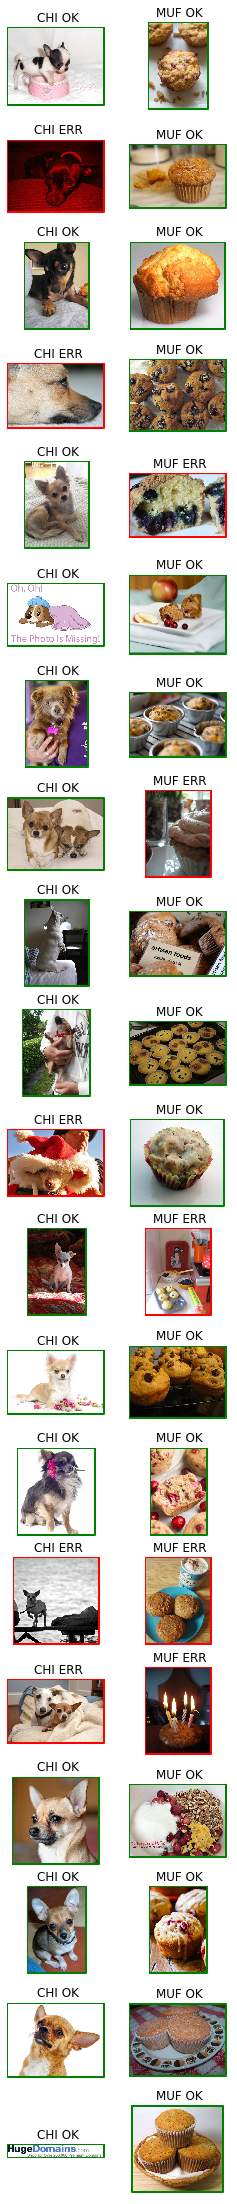

In [78]:
from matplotlib.image import imread

nelem = 20   # number of elements to show

def show_image(imgpath, frame_color, gray=True):
    im = imread(imgpath)
    if gray:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im)
    h, w = im.shape[:2]
    plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    plt.axis('off')

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(4,40))
no = 1  # index current of subfigure
for ii in range(nelem):
    plt.subplot(nelem, 2, 2*ii+1)
    val_img_i = val_imgs_chi[ii]
    x_val_i = x_val_chi[ii]
    y_pred_i = clf.predict(x_val_i.reshape(1,-1))
    expected = 0; classname = "CHI"
    show_image(val_img_i, 'g' if y_pred_i == expected else 'r')
    plt.title(classname + " " + ("OK" if y_pred_i == expected else "ERR"))
    
    plt.subplot(nelem, 2, 2*ii+2)
    val_img_i = val_imgs_muf[ii]
    x_val_i = x_val_muf[ii]
    y_pred_i = clf.predict(x_val_i.reshape(1,-1))
    expected = 1; classname = "MUF"
    show_image(val_img_i, 'g' if y_pred_i == expected else 'r')
    plt.title(classname + " " + ("OK" if y_pred_i == expected else "ERR"))

plt.show()

# 8. Test on meme images
Time for fun: let's test our classifier on the meme images.

In [92]:
meme_test_sifts = !ls $PATH_TO_RESOURCES/meme_siftgeo/*.siftgeo | sort
meme_test_sifts

['/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/chihuahua-1.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/chihuahua-2.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/chihuahua-3.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/chihuahua-4.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/chihuahua-5.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/chihuahua-6.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/chihuahua-7.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/chihuahua-8.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/muffin-1.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/muffin-2.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/muffin-3.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_siftgeo/muffin-4.siftgeo',
 '/h

In [93]:
meme_test_imgs = !ls $PATH_TO_RESOURCES/meme_jpg/*.j*g | sort
meme_test_imgs

['/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/chihuahua-1.jpg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/chihuahua-2.jpg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/chihuahua-3.jpg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/chihuahua-4.jpg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/chihuahua-5.jpg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/chihuahua-6.jpg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/chihuahua-7.jpg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/chihuahua-8.jpg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/muffin-1.jpeg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/muffin-2.jpeg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/muffin-3.jpeg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/muffin-4.jpeg',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//meme_jpg/muffin-5.jpeg',
 '/home/mados/Document

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the descriptors for each image.**
</div>

In [94]:
# TODO 
x_meme_test_descr = compute_descriptors(meme_test_sifts, train_mean, pca_transform, kmeans)
x_meme_test_descr.shape

Indexing ['meme_siftgeo', 'chihuahua-1.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-2.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-3.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-4.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-5.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-6.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-7.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-8.siftgeo']
Indexing ['meme_siftgeo', 'muffin-1.siftgeo']
Indexing ['meme_siftgeo', 'muffin-2.siftgeo']
Indexing ['meme_siftgeo', 'muffin-3.siftgeo']
Indexing ['meme_siftgeo', 'muffin-4.siftgeo']
Indexing ['meme_siftgeo', 'muffin-5.siftgeo']
Indexing ['meme_siftgeo', 'muffin-6.siftgeo']
Indexing ['meme_siftgeo', 'muffin-7.siftgeo']
Indexing ['meme_siftgeo', 'muffin-8.siftgeo']
Indexing complete.


(16, 512)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the target values for the `x_meme_test` vector you created.**
</div>

In [95]:
# TODO
y_true_meme_test = np.array(list(map(lambda path: "muffin" in path , meme_test_sifts))).astype(int)
y_true_meme_test

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

We can compute the score of our classifier on this little sample

In [96]:
clf.score(x_meme_test_descr, y_true_meme_test)

0.9375

We will now display the results for the meme images.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the predicted values for all meme images.**
</div>

In [97]:
# TODO
y_pred_meme_test = clf.predict(x_meme_test_descr)
y_pred_meme_test

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.])

Here is a little code to render the results

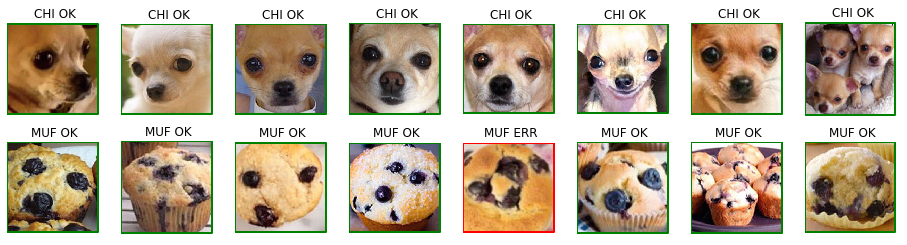

In [98]:
plt.figure(figsize=(16,4))
for ii, (img, y_pred, y_true) in enumerate(zip(meme_test_imgs, y_pred_meme_test, y_true_meme_test)):
    plt.subplot(2, 8, ii+1)
    correct = y_pred == y_true
    show_image(img, 'g' if correct else 'r')
    plt.title(("CHI" if y_true == 0 else "MUF") + " " + ("OK" if correct else "ERR"))

## 9. Compute the results on the test set and export them
You are now ready to process the test data and submit them for grading.

In [99]:
test_sift_files = !ls $PATH_TO_RESOURCES/test_set_sift/*.siftgeo | sort
test_sift_files[:5]

['/home/mados/Documents/TABERNACLE/mlrfrendu/r2//test_set_sift/test_0000.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//test_set_sift/test_0001.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//test_set_sift/test_0002.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//test_set_sift/test_0003.siftgeo',
 '/home/mados/Documents/TABERNACLE/mlrfrendu/r2//test_set_sift/test_0004.siftgeo']

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the BoVW descriptors for each `.siftgeo` file, compute the predicted class, and build the map of results `{test_id: class_name}`.**
</div>

In [100]:
# here is an utility fonction to extract the appropriate part from the path to generate the result id
def path_to_id(path):
    return path[-(9+8):-8]

assert(path_to_id(test_sift_files[0]) == 'test_0000')

In [101]:
# TODO
x_test = compute_descriptors(test_sift_files, train_mean, pca_transform, kmeans)
y_test_pred =  clf.predict(x_test)

Indexing ['test_set_sift', 'test_0000.siftgeo']
Indexing ['test_set_sift', 'test_0001.siftgeo']
Indexing ['test_set_sift', 'test_0002.siftgeo']
Indexing ['test_set_sift', 'test_0003.siftgeo']
Indexing ['test_set_sift', 'test_0004.siftgeo']
Indexing ['test_set_sift', 'test_0005.siftgeo']
Indexing ['test_set_sift', 'test_0006.siftgeo']
Indexing ['test_set_sift', 'test_0007.siftgeo']
Indexing ['test_set_sift', 'test_0008.siftgeo']
Indexing ['test_set_sift', 'test_0009.siftgeo']
Indexing ['test_set_sift', 'test_0010.siftgeo']
Indexing ['test_set_sift', 'test_0011.siftgeo']
Indexing ['test_set_sift', 'test_0012.siftgeo']
Indexing ['test_set_sift', 'test_0013.siftgeo']
Indexing ['test_set_sift', 'test_0014.siftgeo']
Indexing ['test_set_sift', 'test_0015.siftgeo']
Indexing ['test_set_sift', 'test_0016.siftgeo']
Indexing ['test_set_sift', 'test_0017.siftgeo']
Indexing ['test_set_sift', 'test_0018.siftgeo']
Indexing ['test_set_sift', 'test_0019.siftgeo']
Indexing ['test_set_sift', 'test_0020.si

Indexing ['test_set_sift', 'test_0206.siftgeo']
Indexing ['test_set_sift', 'test_0207.siftgeo']
Indexing ['test_set_sift', 'test_0208.siftgeo']
Indexing ['test_set_sift', 'test_0209.siftgeo']
Indexing ['test_set_sift', 'test_0210.siftgeo']
Indexing ['test_set_sift', 'test_0211.siftgeo']
Indexing ['test_set_sift', 'test_0212.siftgeo']
Indexing ['test_set_sift', 'test_0213.siftgeo']
Indexing ['test_set_sift', 'test_0214.siftgeo']
Indexing ['test_set_sift', 'test_0215.siftgeo']
Indexing ['test_set_sift', 'test_0216.siftgeo']
Indexing ['test_set_sift', 'test_0217.siftgeo']
Indexing ['test_set_sift', 'test_0218.siftgeo']
Indexing ['test_set_sift', 'test_0219.siftgeo']
Indexing ['test_set_sift', 'test_0220.siftgeo']
Indexing ['test_set_sift', 'test_0221.siftgeo']
Indexing ['test_set_sift', 'test_0222.siftgeo']
Indexing ['test_set_sift', 'test_0223.siftgeo']
Indexing ['test_set_sift', 'test_0224.siftgeo']
Indexing ['test_set_sift', 'test_0225.siftgeo']
Indexing ['test_set_sift', 'test_0226.si

In [102]:
results = {path_to_id(f):("chi" if y == 0 else "muf") for f,y in zip(test_sift_files, y_test_pred)}
results

{'test_0000': 'chi',
 'test_0001': 'muf',
 'test_0002': 'chi',
 'test_0003': 'muf',
 'test_0004': 'chi',
 'test_0005': 'muf',
 'test_0006': 'chi',
 'test_0007': 'chi',
 'test_0008': 'chi',
 'test_0009': 'muf',
 'test_0010': 'chi',
 'test_0011': 'chi',
 'test_0012': 'chi',
 'test_0013': 'muf',
 'test_0014': 'muf',
 'test_0015': 'muf',
 'test_0016': 'muf',
 'test_0017': 'chi',
 'test_0018': 'chi',
 'test_0019': 'muf',
 'test_0020': 'chi',
 'test_0021': 'muf',
 'test_0022': 'chi',
 'test_0023': 'chi',
 'test_0024': 'chi',
 'test_0025': 'chi',
 'test_0026': 'chi',
 'test_0027': 'chi',
 'test_0028': 'chi',
 'test_0029': 'chi',
 'test_0030': 'chi',
 'test_0031': 'chi',
 'test_0032': 'muf',
 'test_0033': 'chi',
 'test_0034': 'chi',
 'test_0035': 'chi',
 'test_0036': 'muf',
 'test_0037': 'muf',
 'test_0038': 'chi',
 'test_0039': 'muf',
 'test_0040': 'chi',
 'test_0041': 'muf',
 'test_0042': 'muf',
 'test_0043': 'chi',
 'test_0044': 'muf',
 'test_0045': 'muf',
 'test_0046': 'chi',
 'test_0047':

In [103]:
with open("results.json", 'w') as outfile:
    json.dump(results, outfile, indent=1)
!head results.json

{
 "test_0000": "chi",
 "test_0001": "muf",
 "test_0002": "chi",
 "test_0003": "muf",
 "test_0004": "chi",
 "test_0005": "muf",
 "test_0006": "chi",
 "test_0007": "chi",
 "test_0008": "chi",


# Job done!
You completed this session, congratulations!

**Do not forget to submit your `results.json` files!**